# Data loading

In [1]:

import os
import pickle


with open('preprocessed_data.pickle', 'rb') as file:
    filt_dict = pickle.load(file)
    segm_dict = pickle.load(file)
    norm_segm_dict = pickle.load(file)

# Segmentación

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula la longitud de todas las secuencias
lengths = [len(seq) for seq in norm_segm_dict['ABP']]  # Asumiendo ABP como referencia; también puedes combinar las longitudes de CBFV y ICP si es necesario

# Usa el percentil 95 para determinar max_len
max_len = int(np.percentile(lengths, 95))

print("Longitud de padding seleccionada:", max_len)

# Asumiendo que has calculado max_len como se indicó antes
norm_segm_dict['ABP'] = pad_sequences(norm_segm_dict['ABP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['CBFV'] = pad_sequences(norm_segm_dict['CBFV'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['ICP'] = pad_sequences(norm_segm_dict['ICP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')

Longitud de padding seleccionada: 122


# LSTM for ICP waveform

In [3]:
from sklearn.model_selection import train_test_split

X = np.stack((norm_segm_dict['ABP'], norm_segm_dict['CBFV']), axis=-1)  # Forma: [num_samples, timesteps, num_channels]
y = norm_segm_dict['ICP']

y_or = segm_dict['ICP']

original_lengths = np.array([len(seq) for seq in y_or])

# Crear un arreglo de índices
indices = np.arange(len(X))

# Primero dividir en entrenamiento y prueba
indices_train, indices_test = train_test_split(indices, test_size=0.1, random_state=110)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
indices_train, indices_val = train_test_split(indices_train, test_size=0.2, random_state=110)  # 0.25 x 0.8 = 0.2

# Usar estos índices para dividir tus datos originales y estadísticos
X_train, X_val, X_test = X[indices_train], X[indices_val], X[indices_test]
y_train, y_val, y_test = y[indices_train], y[indices_val], y[indices_test]

train_lengths, val_lengths, test_lengths = original_lengths[indices_train], original_lengths[indices_val], original_lengths[indices_test]

In [4]:
import numpy as np
import keras.backend as K
from keras.callbacks import Callback

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.scale_fn = scale_fn
        self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        if self.scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: self.gamma ** (x)
                self.scale_mode = 'iterations'

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        K.set_value(self.model.optimizer.lr, self.clr())
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

# Crear una instancia del callback con los parámetros deseados
clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular2')

In [7]:
!pip install tensorboard


In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Bidirectional, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

seq_length = 122  
input_seq = Input(shape=(seq_length, 2))
lstm_out1 = Bidirectional(LSTM(100, return_sequences=True))(input_seq)
lstm_out = Bidirectional(LSTM(50, return_sequences=True))(lstm_out1)
attention = Attention()([lstm_out, lstm_out])
context_vector = Concatenate()([lstm_out, attention])
output = TimeDistributed(Dense(1))(context_vector)

# Crear y compilar el modelo
model = Model(inputs=input_seq, outputs=output)

model.output

<KerasTensor: shape=(None, 122, 1) dtype=float32 (created by layer 'time_distributed_23')>

In [74]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
loss = Huber(delta=1.0)  # Puede ser 'mae' o Huber()

model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=75, batch_size=64, validation_data=(X_val, y_val), callbacks=[clr, tensorboard_callback])

Epoch 1/75
597/597 [==============================] - 42s 54ms/step - loss: 0.0889 - mae: 0.2780 - val_loss: 0.0670 - val_mae: 0.2324
Epoch 2/75
597/597 [==============================] - 28s 47ms/step - loss: 0.0531 - mae: 0.1996 - val_loss: 0.0457 - val_mae: 0.1815
Epoch 3/75
597/597 [==============================] - 26s 44ms/step - loss: 0.0425 - mae: 0.1712 - val_loss: 0.0395 - val_mae: 0.1651
Epoch 4/75
597/597 [==============================] - 26s 44ms/step - loss: 0.0383 - mae: 0.1592 - val_loss: 0.0363 - val_mae: 0.1542
Epoch 5/75
597/597 [==============================] - 26s 44ms/step - loss: 0.0361 - mae: 0.1515 - val_loss: 0.0351 - val_mae: 0.1522
Epoch 6/75
597/597 [==============================] - 26s 43ms/step - loss: 0.0338 - mae: 0.1447 - val_loss: 0.0325 - val_mae: 0.1391
Epoch 7/75
597/597 [==============================] - 27s 45ms/step - loss: 0.0323 - mae: 0.1400 - val_loss: 0.0341 - val_mae: 0.1480
Epoch 8/75
597/597 [==============================] - 28s 46ms

# Overfitting check before saving


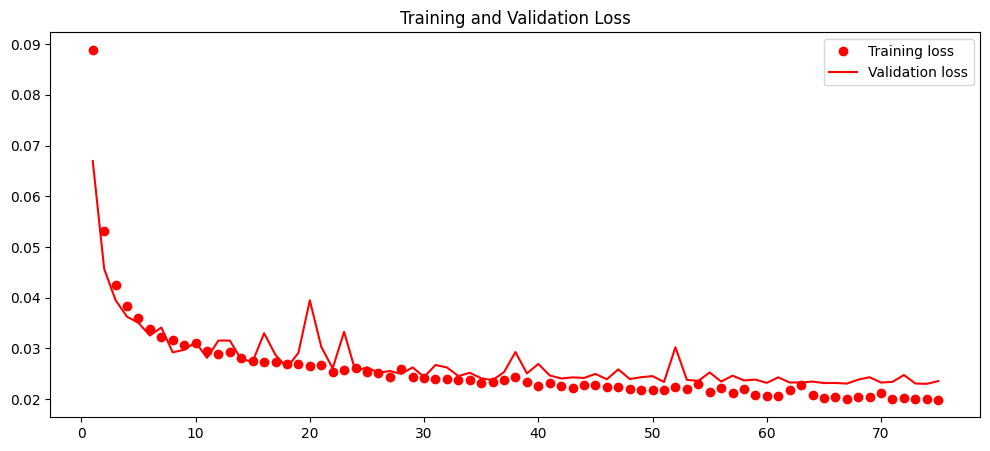

In [75]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, 75 + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

In [76]:
model.save('ModelosLSTM/model1f.h5')

# Pruebas Waveform

166/166 [==============================] - 3s 10ms/step


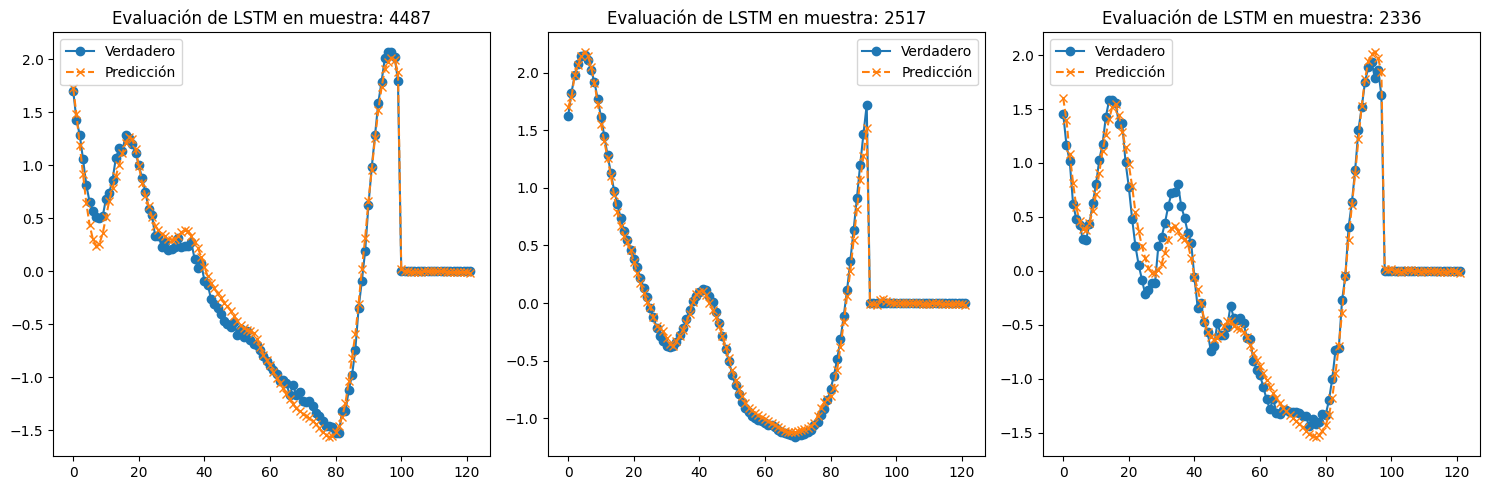

y_test shape: (5299, 122)
predictions shape: (5299, 122, 1)


In [69]:
import numpy as np

# Obtener las predicciones del modelo
predictions = model.predict(X_test)
predictions_trimmed = [pred[:length] for pred, length in zip(predictions, test_lengths)]
y_test_trimmed = [pred[:length] for pred, length in zip(y_test, test_lengths)]

# Seleccionar 20 índices aleatorios para mostrar
num_examples = 3
indices = np.random.choice(len(predictions_trimmed), num_examples, replace=False)
indices = [4486, 2516, 2335]

# Configurar la figura para mostrar múltiples subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # Ajusta el tamaño de la figura según necesidad
axes = axes.flatten()  # Aplanar el array de axes para una iteración más fácil

for idx, ax in zip(indices, axes):
    ax.plot(y_test[idx], label='Verdadero', marker='o', linestyle='-')
    ax.plot(predictions[idx], label='Predicción', marker='x', linestyle='--')
    ax.set_title(f'Evaluación de LSTM en muestra: {idx+1}')
    ax.legend()

# Ajustar el layout para evitar la superposición de subplots
plt.tight_layout()
plt.show()

# Imprimir las dimensiones para referencia
print("y_test shape:", y_test.shape)
print("predictions shape:", predictions.shape)